Data Exploration

In [1]:
import sys
from pathlib import Path
# Add the project root directory to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from managers import StockDataManager
manager = StockDataManager()
stock_info_df = manager.get_stock_info_df()

ah_df = manager.get_all_ah_candlesticks_df()

In [8]:
ah_df['00811']['data']['a']

,date,open,close,high,low,volume,amount,change,turnover_rate
0,2023-12-27T00:00:00+08:00,13.44,13.32,13.54,13.24,3088200,41220000.0,-0.0148,0.003900
1,2023-12-28T00:00:00+08:00,13.32,13.12,13.36,13.08,4534100,59830000.0,-0.0150,0.005726
2,2023-12-29T00:00:00+08:00,13.13,13.66,13.73,13.13,4468500,60610000.0,0.0412,0.005643
3,2024-01-02T00:00:00+08:00,13.66,13.62,13.88,13.58,5068300,69340000.0,-0.0029,0.006400
4,2024-01-03T00:00:00+08:00,13.50,13.82,14.06,13.35,4304600,59290000.0,0.0147,0.005436
...,...,...,...,...,...,...,...,...,...
237,2024-12-20T00:00:00+08:00,16.58,16.58,16.73,16.47,3873000,61230000.0,0.0044,0.004891
238,2024-12-23T00:00:00+08:00,16.59,16.30,16.65,16.24,4383000,68690000.0,-0.0177,0.005535
239,2024-12-24T00:00:00+08:00,16.39,16.83,16.83,16.31,5209700,82810000.0,0.0341,0.006579
240,2024-12-25T00:00:00+08:00,16.82,16.83,16.92,16.57,4527600,72310000.0,0.0000,0.005717


In [84]:
ah_df['00811']['data']['hk']

,date,open,close,high,low,volume,amount,change,turnover_rate
0,2023-12-27T00:00:00+08:00,6.6000,6.8000,6.8600,6.6000,457000,3084300.0,0.0319,0.000370
1,2023-12-28T00:00:00+08:00,6.7600,6.9000,6.9700,6.7600,1148000,7943000.0,0.0147,0.000930
2,2023-12-29T00:00:00+08:00,6.9100,6.9500,7.0100,6.9100,967000,6744700.0,0.0072,0.000784
3,2024-01-02T00:00:00+08:00,6.9300,6.8000,6.9300,6.7700,368000,2513700.0,-0.0216,0.000298
4,2024-01-03T00:00:00+08:00,6.8000,6.9000,7.0000,6.8000,542000,3749600.0,0.0147,0.000439
...,...,...,...,...,...,...,...,...,...
241,2024-12-18T00:00:00+08:00,11.7006,11.9606,11.9606,11.6606,1571000,17670200.0,0.0235,0.001273
242,2024-12-19T00:00:00+08:00,11.7606,11.9806,12.0606,11.6606,1632000,18384900.0,0.0018,0.001323
243,2024-12-20T00:00:00+08:00,11.9406,12.0006,12.1006,11.8406,1542000,17509200.0,0.0018,0.001250
244,2024-12-23T00:00:00+08:00,11.8606,12.1006,12.1806,11.8606,1902900,21816500.0,0.0088,0.001542


Data Manipulation

In [9]:
import pybroker
from pybroker import Strategy, StrategyConfig
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

In [58]:
def prepare_data(ah_df):
    result_data = []
    
    for stock_code in ah_df.keys():
        # Only process if both HK and A shares data exist
        if 'hk' in ah_df[stock_code]['data'] and 'a' in ah_df[stock_code]['data']:
            hk_df = ah_df[stock_code]['data']['hk'].copy()
            a_df = ah_df[stock_code]['data']['a'].copy()
            
            # Convert dates to datetime for merging
            hk_df['date'] = pd.to_datetime(hk_df['date'])
            a_df['date'] = pd.to_datetime(a_df['date'])
            
            # Calculate ratio by matching dates
            # Merge the dataframes on date and calculate ratio
            a_df_unique = a_df[['date', 'close']].drop_duplicates(subset='date')
            merged_df = pd.merge(hk_df, a_df_unique, on='date', how='left', suffixes=('', '_a'))
            hk_df['ratio'] = merged_df['close_a'] / hk_df['close']
            
            # Add stock_code as symbol to the dataframe
            hk_df['symbol'] = f"{stock_code}"
            result_df = hk_df[['date', 'symbol', 'open', 'high', 'low',
                             'close', 'ratio']]
            result_df.shift(periods=1, axis = 0, fill_value = None)
            result_data.append(result_df)
        else:
            raise ValueError(f"No HK or A shares data for {stock_code}")
        
    # Combine all dataframes
    if result_data:
        final_df = pd.concat(result_data, ignore_index=True)
        return final_df
    return pd.DataFrame()


In [59]:
# Prepare data
ah_data_ratios = prepare_data(ah_df)

In [89]:
ah_data_ratios_1 = ah_data_ratios.drop_duplicates(subset=["date", "symbol"])

In [91]:
ah_data_ratios["date"] = ah_data_ratios["date"].dt.tz_localize(None)

In [90]:
print(len(ah_data_ratios_1), len(ah_data_ratios))

35931 35931


In [61]:
len(ah_data_ratios.symbol.unique())

148

In [62]:
ah_data_ratios.dtypes

date      datetime64[ns, UTC+08:00]
symbol                       object
open                        float64
high                        float64
low                         float64
close                       float64
ratio                       float64
dtype: object

In [94]:
import pandas as pd
import numpy as np
import bt

class RunOnFirstTradingDayOfMonth(bt.Algo):
    """
    This algo returns True only if the current date target.now
    is the *first trading day* of that month (based on actual data index).
    We store those dates (once) by scanning the data's index to find
    the earliest date for each month.
    """
    def __init__(self):
        super(RunOnFirstTradingDayOfMonth, self).__init__()
        self.first_days = None

    def __call__(self, target):
        # Build self.first_days set once
        if self.first_days is None:
            dts = target.data.dropna(how="all").index
            self.first_days = set()
            last_month = None
            for dt in dts:
                month_key = (dt.year, dt.month)
                if month_key != last_month:
                    self.first_days.add(dt)
                    last_month = month_key

        # Return True if today's date is one of those "first trading days"
        return target.now in self.first_days


class SelectTop10ByRatio(bt.Algo):
    """
    On the days we return True (from RunOnFirstTradingDayOfMonth),
    this picks the top 10 stocks by ratio from ratio_data_key.
    """
    def __init__(self, ratio_data_key="ratio_wide"):
        super(SelectTop10ByRatio, self).__init__()
        self.ratio_data_key = ratio_data_key

    def __call__(self, target):
        ratio_data = target.get_data(self.ratio_data_key)
        if target.now in ratio_data.index:
            # pick top 10 by ratio
            row = ratio_data.loc[target.now].dropna()
            top10 = row.nlargest(10).index.tolist()
        else:
            top10 = []

        # Save to temp
        target.temp["top10"] = top10
        return True


class WeighEquallyTop10(bt.Algo):
    """
    Create the weights dict with each stock in top10 having equal weight.
    If no top10 is found, hold zero positions.
    """
    def __call__(self, target):
        top10 = target.temp.get("top10", [])
        if len(top10) == 0:
            # empty weighting
            target.temp["weights"] = {}
        else:
            w = 1.0 / len(top10)
            target.temp["weights"] = {name: w for name in top10}
        return True


def run_simplified_backtest(ah_data_ratios: pd.DataFrame):
    """
    This function runs a simplified backtest using the bt framework:
      - On the *first trading day of each month*, pick top 10 ratio stocks.
      - Immediately buy equally among those 10 stocks (rebalancing the entire portfolio).
      - Start capital is 1,000,000.
      - The input 'ah_data_ratios' must be timezone-naive and sorted ascending by date.
      - Backtest between 2024-01-01 and 2024-12-26 (naive dates).
    
    Required columns in ah_data_ratios:
        ['date', 'symbol', 'close', 'ratio']
    (Other columns ignored here.)

    Returns
    -------
    bt.Result
    """

    # 1) Sort the raw DataFrame by date (assumed naive, ascending).
    df = ah_data_ratios.copy().sort_values(["date", "symbol"])

    # 2) Create wide data frames:
    close_wide = df.pivot(index="date", columns="symbol", values="close")
    ratio_wide = df.pivot(index="date", columns="symbol", values="ratio")

    # 3) Trim date range
    start_date, end_date = pd.to_datetime("2024-01-01"), pd.to_datetime("2024-12-26")
    close_wide = close_wide.loc[(close_wide.index >= start_date) & (close_wide.index <= end_date)]
    ratio_wide = ratio_wide.loc[(ratio_wide.index >= start_date) & (ratio_wide.index <= end_date)]

    # 4) Define Strategy
    # We'll run daily, but only place trades on the first trading day of each month.
    # On that day, we pick top 10 ratio and allocate equally.
    strategy = bt.Strategy(
        "Top10Monthly",
        algos=[
            bt.algos.RunDaily(),             # Check daily
            RunOnFirstTradingDayOfMonth(),   # True only on the first day in a month
            SelectTop10ByRatio("ratio_wide"),
            WeighEquallyTop10(),
            bt.algos.Rebalance(),
        ],
    )

    # 5) Build backtest
    backtest = bt.Backtest(
        strategy=strategy,
        data=close_wide,
        initial_capital=1_000_000,
        name="AH_Simplified",
        additional_data={"ratio_wide": ratio_wide},
    )

    # 6) Run
    res = bt.run(backtest)
    return res

# ------------------------------------------------------------------------------
# Usage example (pseudo-code):
#
# your_data = pd.DataFrame({
#     'date': [...],      # naive datetimes
#     'symbol': [...],
#     'close': [...],
#     'ratio': [...],
# })
# result = run_simplified_backtest(your_data)
# print(result.display())
# result.plot()
# ------------------------------------------------------------------------------

In [96]:
result = run_simplified_backtest(ah_data_ratios)
print(result.display())


100%|██████████| 1/1 [00:00<00:00, 17.99it/s]

Stat                 AH_Simplified
-------------------  ---------------
Start                2024-01-01
End                  2024-12-24
Risk-free rate       0.00%

Total Return         95.42%
Daily Sharpe         2.01
Daily Sortino        5.25
CAGR                 98.09%
Max Drawdown         -14.91%
Calmar Ratio         6.58

MTD                  2.00%
3m                   74.32%
6m                   83.13%
YTD                  95.42%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  98.09%

Daily Sharpe         2.01
Daily Sortino        5.25
Daily Mean (ann.)    76.35%
Daily Vol (ann.)     37.94%
Daily Skew           3.71
Daily Kurt           26.34
Best Day             21.08%
Worst Day            -4.82%

Monthly Sharpe       1.94
Monthly Sortino      9.97
Monthly Mean (ann.)  82.48%
Monthly Vol (ann.)   42.55%
Monthly Skew         1.47
Monthly Kurt         2.30
Best Month           35.83%
Worst Month          -6.32%

Yearl

<Axes: title={'center': 'Equity Progression'}>

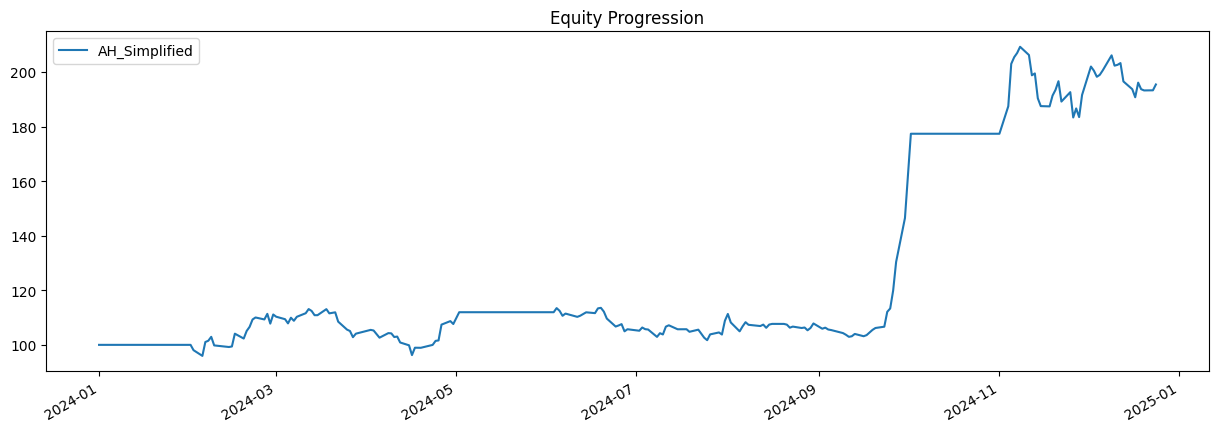

In [97]:
result.plot()

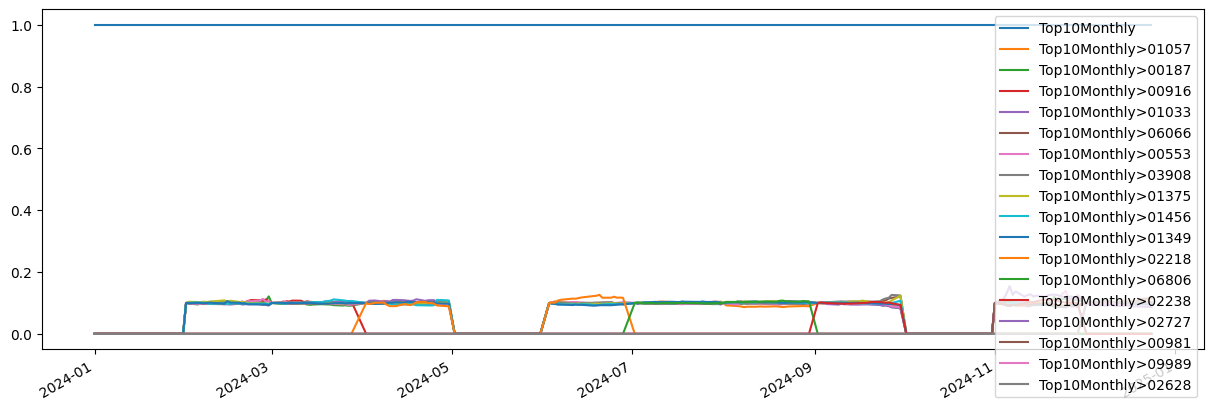

In [99]:
result.plot_weights()

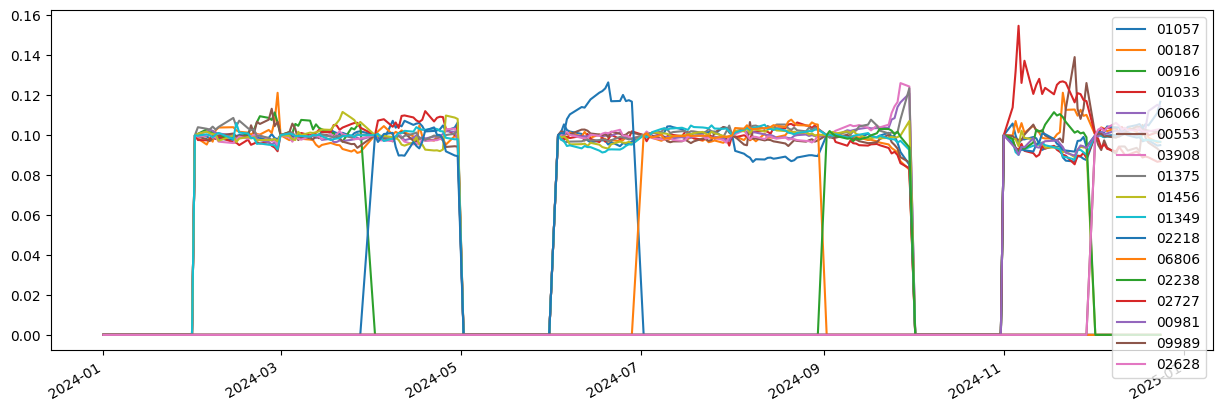

In [101]:
result.plot_security_weights()

In [104]:
result.get_transactions().to_csv("transactions.csv")

In [105]:
result.get_transactions()

,01057,00187,00916,01033,06066,00553,03908,01375,01456,01349,02218,06806,02238,02727,00981,09989,02628
2024-01-01,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-01-02,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-01-03,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-01-04,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-01-05,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18,0.096924,0.099999,0.0,0.103009,0.0,0.105111,0.0,0.0,0.0,0.097798,0.103608,0.0,0.0,0.088822,0.101251,0.101516,0.101951
2024-12-19,0.097473,0.101234,0.0,0.102748,0.0,0.098695,0.0,0.0,0.0,0.097499,0.105495,0.0,0.0,0.089295,0.103292,0.102519,0.101740
2024-12-20,0.097380,0.098760,0.0,0.099919,0.0,0.096264,0.0,0.0,0.0,0.097731,0.104895,0.0,0.0,0.088882,0.112051,0.102258,0.101849
2024-12-23,0.094758,0.096363,0.0,0.101433,0.0,0.093309,0.0,0.0,0.0,0.096953,0.111069,0.0,0.0,0.086671,0.115192,0.101477,0.102763


In [106]:
result.display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
  2024      0  11.13  -6.32    3.4   4.02  -5.57   2.94  -0.91  35.83  21.08   8.02      2  95.42


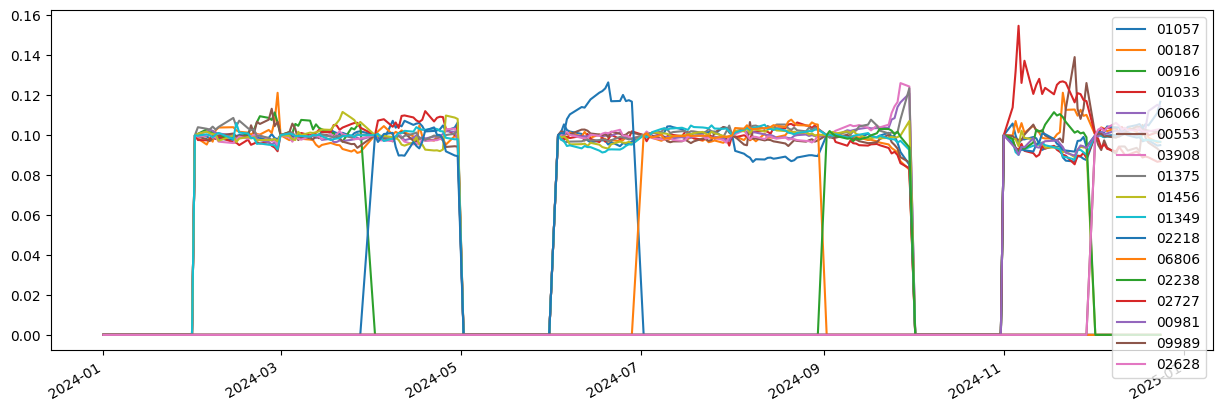

In [108]:
result.plot_security_weights()

AH premium streategy backtest